In [1]:
import torch
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import os
import seaborn as sns
from torch import optim
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image

In [2]:
dataset_path = ".\\Dataset"

init_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(dataset_path, transform=init_transforms)

In [3]:
generator = torch.Generator().manual_seed(42)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2], generator)

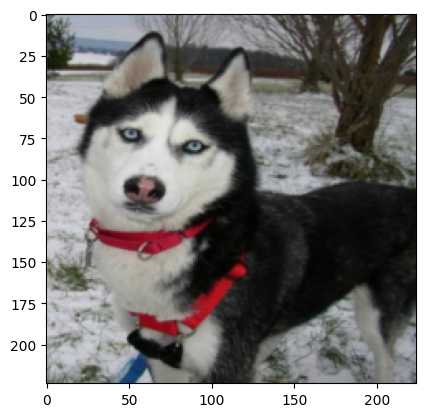

In [4]:
plt.imshow(dataset_train[0][0].permute(1, 2, 0))

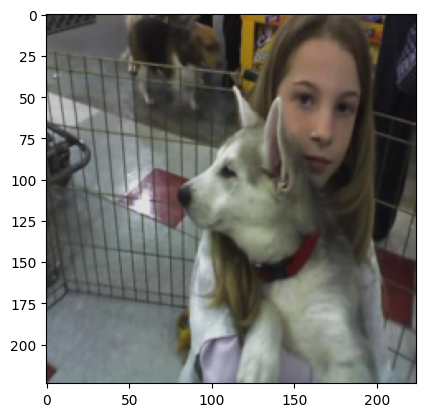

In [5]:
plt.imshow(dataset_train[8777][0].permute(1, 2, 0))

c:\python39\lib\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


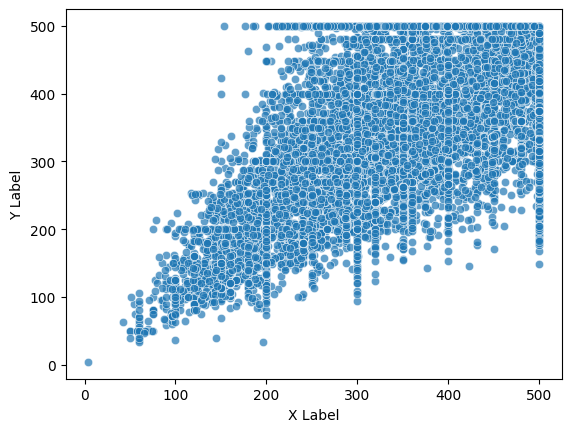

In [6]:
# Finding a good shape to resize to
widths = []
heights = []

for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)
    
    for img_name in os.listdir(subdir_path):
        img_path = os.path.join(subdir_path, img_name)
        img = Image.open(img_path)
        img_shape = (img.width, img.height)
        
        widths.append(img_shape[0])
        heights.append(img_shape[1])

# Alpha is transperancy
sns.scatterplot(x=widths, y=heights, alpha=0.7)

plt.xlabel("X Label")
plt.ylabel("Y Label")

plt.show()

In [7]:
# Defining the CNN
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        conv5_layers = [
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5)),
            nn.ReLU(),
            #nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5)),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        ]
        self.conv_5 = nn.Sequential(*conv5_layers)
        conv3_layers = [
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3)),
            nn.ReLU(),
            #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        ]
        self.conv_3 = nn.Sequential(*conv3_layers)
        self.fc = nn.Linear(46656, num_classes)
        
    def forward(self, x):
        x = self.conv_5(x)
        x = self.conv_3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [8]:
# Initialize the model

model = CNN().to(torch.device("cuda"))

In [9]:
# Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize DataLoaders for our datasets
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# Used for plotting later
train_losses = []
test_losses = []

train_data = dataset_train[0]
train_labels = dataset_train[1]
test_data = dataset_test[0]
test_labels = dataset_test[1]

for epoch in range(10):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device="cuda")
        labels = labels.to(device="cuda")
        
        # Forward pass
        scores = model(data)
        loss = criterion(scores, labels)
        
        train_losses.append(loss)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Adam step
        optimizer.step()
        
    print("Finished epoch {}".format(epoch))

c:\python39\lib\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9


In [13]:
my_filter = model.conv_5[0].weight.data.clone()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


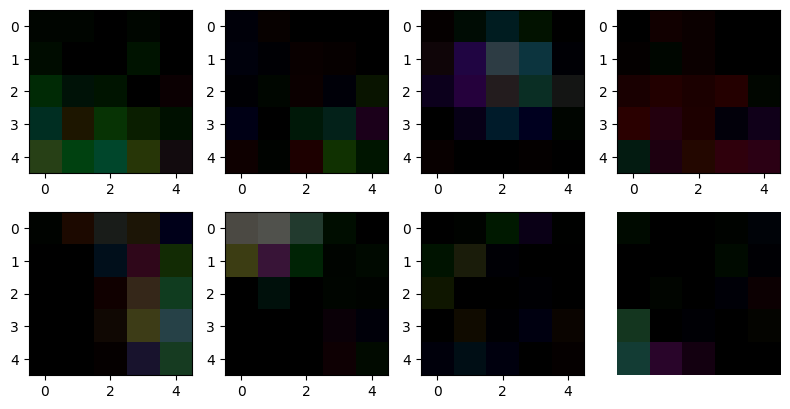

In [19]:
fig = plt.figure(figsize=(8,8))

for i, kernel in enumerate(my_filter):
    kernel = kernel.cpu()
    
    fig.add_subplot(4, 4, i+1)
    plt.imshow(kernel.permute(1, 2, 0))

plt.axis("off")
plt.tight_layout()

plt.show()

In [21]:
error_count = 0

with torch.no_grad():
    num_correct = 0
    num_samples = 0
    
    for x, y in test_loader:
        x = x.to(device="cuda")
        y = y.to(device="cuda")
        
        scores = model(x)
        
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)
        
    print("Num Correct={}/Num Samples={}".format(num_correct, num_samples))

Num Correct=3619/Num Samples=4999
